In [1]:
import scipy
from scipy import stats
import scipy.integrate as spi
import numpy as np
import pylab as pl
import pandas as pd
import math
import xlrd
import sys
import time

%matplotlib inline

In [19]:
filename = 'Italy_infected.xlsx'
book = xlrd.open_workbook(filename)
print('Source file: ' + sys.path[0] + filename + ' loaded!')

#Extraction
nsheets = book.nsheets

sheet_names = book.sheet_names()
sheets = {}

for sheet_name in sheet_names:    
    nrows = book.sheet_by_name(sheet_name).nrows
    current_header = book.sheet_by_name(sheet_name).row_values(0) 
    current_data = [book.sheet_by_name(sheet_name).row_values(i) for i in range(1, nrows)]
    sheets[sheet_name] = pd.DataFrame(current_data, columns = current_header)   #DataFrame Construction
#Feedback
print('Data Extracted!')

Source file: E:\Chuan\Documents\GitHub\Research\SEIRItaly_infected.xlsx loaded!
Data Extracted!


In [22]:
sheets

{'Italy':              infected  recovered   death          
 0   43881.0       3.0        0.0     1.0       1.0
 1   43882.0      20.0        0.0     1.0       1.0
 2   43883.0      62.0        1.0     2.0       3.0
 3   43884.0     155.0        2.0     3.0       5.0
 4   43885.0     229.0        1.0     7.0       8.0
 5   43886.0     322.0        1.0    10.0      11.0
 6   43887.0     453.0        3.0    12.0      15.0
 7   43888.0     655.0       45.0    17.0      62.0
 8   43889.0     888.0       46.0    21.0      67.0
 9   43890.0    1128.0       46.0    29.0      75.0
 10  43891.0    1694.0       83.0    34.0     117.0
 11  43892.0    2036.0      149.0    52.0     201.0
 12  43893.0    2502.0      160.0    79.0     239.0
 13  43894.0    3089.0      276.0   107.0     383.0
 14  43895.0    3858.0      414.0   148.0     562.0
 15  43896.0    4636.0      523.0   197.0     720.0
 16  43897.0    5883.0      589.0   233.0     822.0
 17  43898.0    7375.0      622.0   366.0     988.0
 18

In [4]:
infected_observed = sheets['Sheet2']['infected']

In [5]:
removed_observed = sheets['Sheet2']['recovered'] + sheets['Sheet2']['death'] 

In [18]:
removed_observed

0        1.0
1        1.0
2        3.0
3        5.0
4        8.0
5       11.0
6       15.0
7       62.0
8       67.0
9       75.0
10     117.0
11     201.0
12     239.0
13     383.0
14     562.0
15     720.0
16     822.0
17     988.0
18    1187.0
19    1355.0
20    1872.0
21    1872.0
22    2705.0
23    3407.0
24    4144.0
25    4907.0
dtype: float64

In [6]:
len(removed_observed)

26

## Iteratible SIR Model

In [7]:
t_start = 0.0
t_end = len(removed_observed)+1       # Transmit Time

N = 6 * math.pow(10,6)
R0 = 0
I0 = 3      # Initial Number of Infectious
S0 = N - I0 - R0    # Initial Number of Susceptible

INPUT = (S0, I0, R0)

def model_SIR(INP,t):  
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1]/N                    # Y[0] is dS(t)/dt, V[0] is S(t)
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]       # Y[1] is dI(t)/dt, V[1] is I(t)
    Y[2] = gamma * V[1]                            # Y[2] is dR(t)/dt.
    return Y   # For odeint

t_range = np.arange(t_start, t_end)

## Interation

In [9]:
start = time.time()

minimum_infected = math.pow(10,10)
minimum_removed = math.pow(10,10)

for beta in np.arange(0.1, 1.0, 0.01):
    for gamma in np.arange(0.1, 1.0, 0.01):
        RES = spi.odeint(model_SIR, INPUT, t_range) 
        
        # Goodness Test of Fitness
        
        #print(RES)
        
        fitness_infected = stats.chisquare(infected_observed, RES[1:, 1])
        fitness_removed = stats.chisquare(removed_observed, RES[1:, 2])
        
       
        if fitness_infected[0] < 10000 and fitness_infected[0] > 0 and fitness_removed[0] < 10000 and fitness_removed[0] > 0:
            print('beta=', beta, '  gamma=', gamma, fitness_infected, fitness_removed)
        
        
        #print('beta=', beta, '  gamma=', gamma, fitness_infected, fitness_removed)
            
        if fitness_infected[0] < minimum_infected and fitness_infected[0]> -minimum_infected and fitness_removed[0] < minimum_removed and fitness_removed[0]> -minimum_removed:
            minimum_infected = fitness_infected[0]
            minimum_removed = fitness_removed[0]
            beta_mini = beta
            gamma_mini = gamma
            
end = time.time()
duration = end - start
            
print('The minimum_infected Z is ', minimum_infected)
print('The minimum_removed Z is ', minimum_removed)
print('when beta is ', beta_mini)
print('when gamma is ', gamma_mini)

print('Time: ', duration)

The minimum_infected Z is  259181.27247996267
The minimum_removed Z is  7350.145280646109
when beta is  0.44999999999999984
when gamma is  0.1
Time:  22.161731958389282


In [10]:
print('The minimum_infected Z is ', minimum_infected)
print('The minimum_removed Z is ', minimum_removed)
print('when beta is ', beta_mini)
print('when gamma is ', gamma_mini)

The minimum_infected Z is  259181.27247996267
The minimum_removed Z is  7350.145280646109
when beta is  0.44999999999999984
when gamma is  0.1


Text(0, 0.5, 'Infectious and Recovereds')

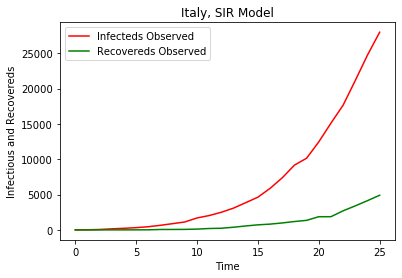

In [11]:
#Ploting
pl.plot(infected_observed, '-r', label='Infecteds Observed')
pl.plot(removed_observed, '-g', label='Recovereds Observed')

pl.legend(loc=0)
pl.title('Italy, SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')

## SIR Validation

In [13]:
beta = 0.45
gamma = 0.1

t_start = 0.0
t_end = 50      # Transmit Time

N = 6*math.pow(10,6)
R0 = 0
I0 = 3      # Initial Number of Infectious
S0 = N - I0 - R0    # Initial Number of Susceptible

INPUT = (S0, I0, R0)

In [14]:
def model_SIR(INP,t):  
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1]/N                    # Y[0] is dS(t)/dt, V[0] is S(t)
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]       # Y[1] is dI(t)/dt, V[1] is I(t)
    Y[2] = gamma * V[1]                            # Y[2] is dR(t)/dt.
    return Y   # For odeint


In [15]:
t_range = np.arange(t_start, t_end)

RES = spi.odeint(model_SIR, INPUT, t_range)   # INPUT is the first parameter of func diff_eqs
                                             # t_range is the second parameter of func diff_eqs

Text(0, 0.5, 'Infectious and Recovereds')

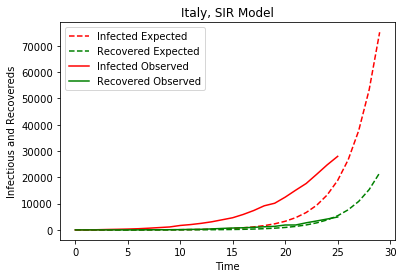

In [16]:
#Ploting
day = 30
pl.plot(RES[:day,1], '--r', label='Infected Expected')
pl.plot(RES[:day,2], '--g', label='Recovered Expected')
pl.plot(infected_observed[:day], '-r', label='Infected Observed')
pl.plot(removed_observed[:day], '-g', label='Recovered Observed')

pl.legend(loc=0)
pl.title('Italy, SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')

Text(0, 0.5, 'Infectious and Recovereds')

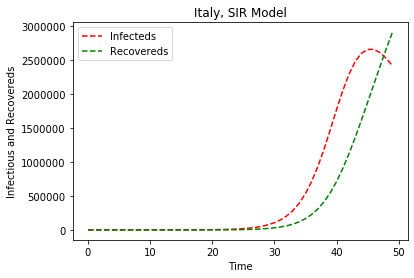

In [17]:
#Ploting
pl.plot(RES[:,1], '--r', label='Infecteds')
pl.plot(RES[:,2], '--g', label='Recovereds')

pl.legend(loc=0)
pl.title('Italy, SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')